# Business Understanding

Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers.

In [815]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [816]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [817]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test])

In [818]:
print(train.shape)
print(test.shape)

(614, 14)
(367, 13)


# Data Understanding

The following are the features present in the given data along with their descriptions:

- Loan_ID 	Unique Loan ID
- Gender 	Male/ Female
- Married 	Applicant married (Y/N)
- Dependents 	Number of dependents
- Education 	Applicant Education (Graduate/ Under Graduate)
- Self_Employed 	Self employed (Y/N)
- ApplicantIncome 	Applicant income
- CoapplicantIncome 	Coapplicant income
- LoanAmount 	Loan amount in thousands
- Loan_Amount_Term 	Term of loan in months
- Credit_History 	credit history meets guidelines
- Property_Area 	Urban/ Semi Urban/ Rural
- Loan_Status 	(Target) Loan approved (Y/N)

The target variable is the Loan Status which is a binary categorical variable with simple output of Yes or No

In [565]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,train
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,train
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,train
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,train
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,train


In [566]:
data.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777.0,113.0,360.0,1.0,Urban,NaN,test
363,LP002975,Male,Yes,0,Graduate,No,4158,709.0,115.0,360.0,1.0,Urban,NaN,test
364,LP002980,Male,No,0,Graduate,No,3250,1993.0,126.0,360.0,NaN,Semiurban,NaN,test
365,LP002986,Male,Yes,0,Graduate,No,5000,2393.0,158.0,360.0,1.0,Rural,NaN,test
366,LP002989,Male,No,0,Graduate,Yes,9200,0.0,98.0,180.0,1.0,Rural,NaN,test


In [567]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        614 non-null    object 
 13  source             981 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 115.0+ KB


In [568]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [569]:
def remove_duplicates(data):
    print("Before Removing the Duplicates: ", data.shape)
    data.drop_duplicates(keep=False, inplace=True)
    print("After Removing the Duplicates: ", data.shape)

In [570]:
remove_duplicates(data)

Before Removing the Duplicates:  (981, 14)
After Removing the Duplicates:  (981, 14)


In [571]:
def display_unique(data):
    for column in data.columns :
        
        print("No of Unique Values in "+column+" Column are : "+str(data[column].nunique()))
        print("Actual Unique Values in "+column+" Column are : "+str(data[column].sort_values(ascending=True,na_position='last').unique() ))
        print("NULL Values :")
        print(data[ column ].isnull().sum())
        print("Value Counts :")
        print(data[column].value_counts())
        print("")

In [572]:
display_unique(data)

No of Unique Values in Loan_ID Column are : 981
Actual Unique Values in Loan_ID Column are : ['LP001002' 'LP001003' 'LP001005' 'LP001006' 'LP001008' 'LP001011'
 'LP001013' 'LP001014' 'LP001015' 'LP001018' 'LP001020' 'LP001022'
 'LP001024' 'LP001027' 'LP001028' 'LP001029' 'LP001030' 'LP001031'
 'LP001032' 'LP001034' 'LP001035' 'LP001036' 'LP001038' 'LP001041'
 'LP001043' 'LP001046' 'LP001047' 'LP001050' 'LP001051' 'LP001052'
 'LP001054' 'LP001055' 'LP001056' 'LP001059' 'LP001066' 'LP001067'
 'LP001068' 'LP001073' 'LP001078' 'LP001082' 'LP001083' 'LP001086'
 'LP001087' 'LP001091' 'LP001094' 'LP001095' 'LP001096' 'LP001097'
 'LP001098' 'LP001099' 'LP001100' 'LP001105' 'LP001106' 'LP001107'
 'LP001108' 'LP001109' 'LP001112' 'LP001114' 'LP001115' 'LP001116'
 'LP001119' 'LP001120' 'LP001121' 'LP001123' 'LP001124' 'LP001128'
 'LP001131' 'LP001135' 'LP001136' 'LP001137' 'LP001138' 'LP001144'
 'LP001146' 'LP001149' 'LP001151' 'LP001153' 'LP001155' 'LP001157'
 'LP001163' 'LP001164' 'LP001169' 'L

In [573]:
data.isna().sum()

Loan_ID                0
Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
source                 0
dtype: int64

In [574]:
data.shape

(981, 14)

In [575]:
train.shape

(614, 14)

In [576]:
test.shape

(367, 13)

In [577]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,train
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,train
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,train
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,train
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,train


# Hypothesis Generation

- Females tend to get more loan approvals than Males.
- Higher Applicant Incomes increases the chances of Loan Approval.
- Married couples with equal Co-applicant income have better chance of Loan Approval.
- Self-Employed persons have lesser chance to be approved for loans.
- Having dependents decreases the chances to loan approval.
- Education does not impact the loan status as long as the person has high and genuine Applicant Income.
- The loan amount depends on the Applicant Income for approval.
- Short Term Loans will get easier approvals.
- Credit History is integral for loan amount status, if not present it leads to disapporval.
- Urban area properties have more chances to be approved for loans

# Data Preparation and Exploration

## Gender

- The number of males is predominantly greater than the number of females in the dataset, and hence it makes it highly imbalanced.
- Number of Married Males is much higher unmarried Males, while in case of females, higher number of females are unmarried compared to the married count.
- There are higher number of graduates in both the genders.
- Self-Employment is lesser in both the genders.
- The male income and female income have the same median, and almost equally distributed except the fact that the male income has many outliers.
- The coapplicant income is slightly greater for males, but there are more outliers for females.
- Males have got slightly higher amounts for loans.
- The majority of loan terms are of 360 days.
- There are more credit histories available for Males, which is obvious since the data is imbalanced, and same can be said about Loan Approvals.

Insight: We need to balance the data, before any processing through solving class imbalance maybe using Synthetic Minority Oversampling or Undersampling the majority class which is males before making the model.

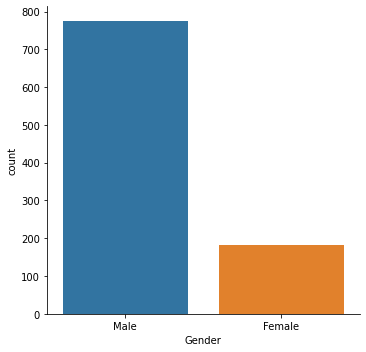

In [136]:
sns.catplot(kind='count', x='Gender', data=data)

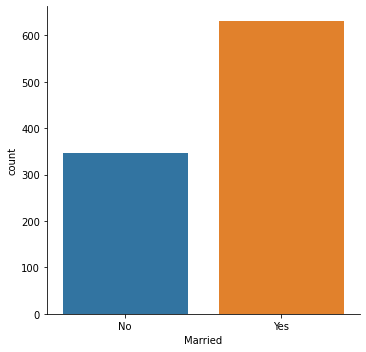

In [137]:
sns.catplot(kind='count', x='Married', data=data)

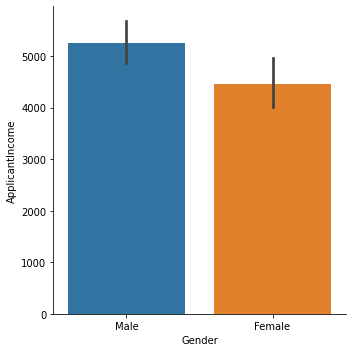

In [138]:
sns.catplot(kind='bar', x='Gender', y='ApplicantIncome', data=data)

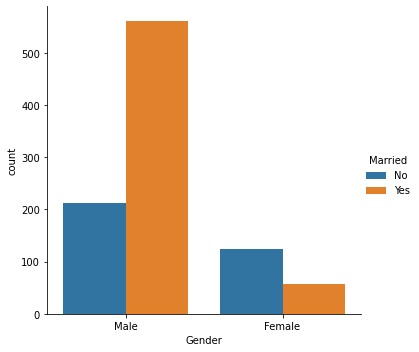

In [139]:
sns.catplot(kind='count', x='Gender', hue='Married', data=data)

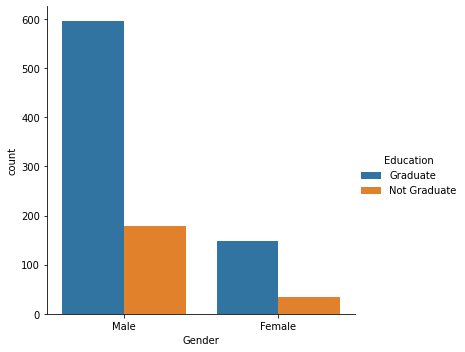

In [140]:
sns.catplot(kind='count', x='Gender', hue='Education', data=data)

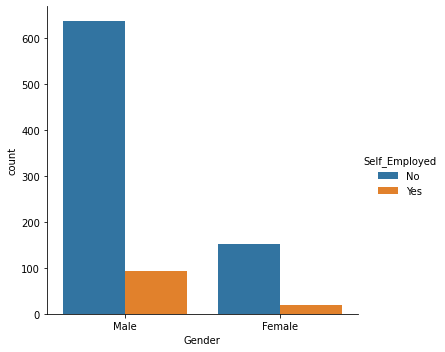

In [141]:
sns.catplot(kind='count', x='Gender', hue='Self_Employed', data=data)

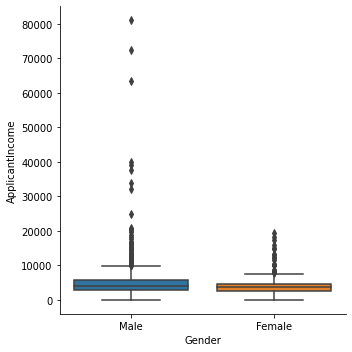

In [142]:
sns.catplot(kind='box', x='Gender', y='ApplicantIncome', data=data)

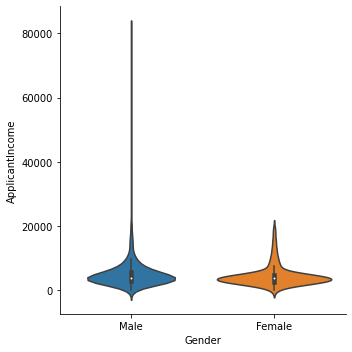

In [143]:
sns.catplot(kind='violin', x='Gender', y='ApplicantIncome', data=data)

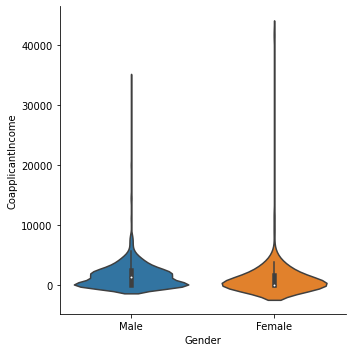

In [144]:
sns.catplot(kind='violin', x='Gender', y='CoapplicantIncome', data=data)

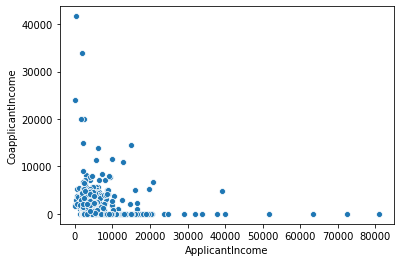

In [145]:
sns.scatterplot(x='ApplicantIncome', y='CoapplicantIncome', data=data)

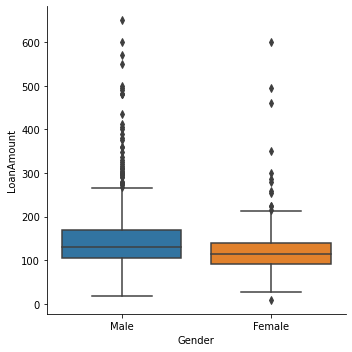

In [146]:
sns.catplot(kind='box', x='Gender', y='LoanAmount', data=data)

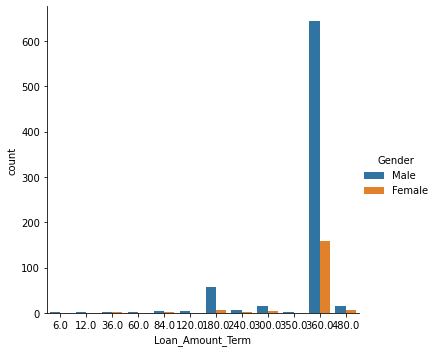

In [147]:
sns.catplot(kind='count', x='Loan_Amount_Term', hue='Gender', data=data)

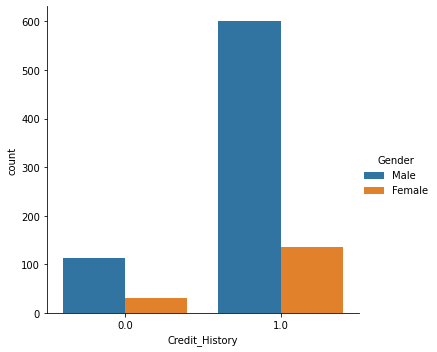

In [148]:
sns.catplot(x='Credit_History', kind='count', hue='Gender', data=data)

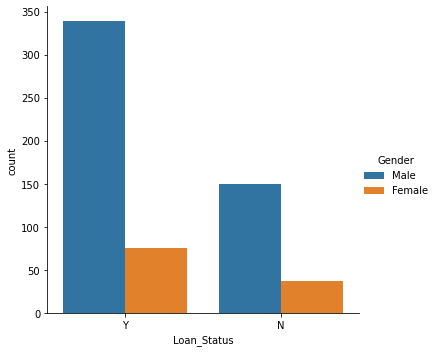

In [149]:
sns.catplot(kind='count', x='Loan_Status', hue='Gender', data=data)

## Married

- The number of married applicants is greater than singles.
- Males are largely more married than females in the given data.
- The number of dependents is higher for married couples which is obvious.
- Married Couples are more educated than singles.
- There are many outliers in the Married applicant incomes. Nevertheless, it is almost equally distributed as singles.
- Very few married people are self-employed.
- The number of married people having approved loans is higher than the single people.
- Higher coapplicant incomes and loan approvals in case of married couples by a slight amount.
- Married couples have better loan amounts than singles.
- Married applicants have more readily available credit histories

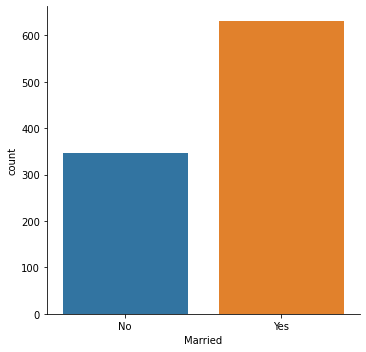

In [150]:
sns.catplot(kind='count', x='Married', data=data)

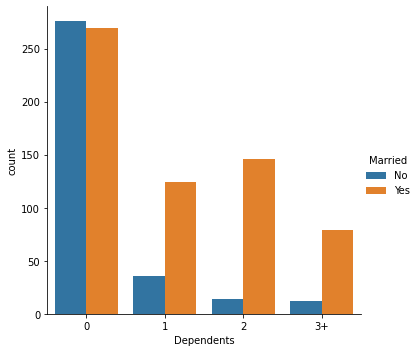

In [151]:
sns.catplot(kind='count', x='Dependents', hue='Married', data=data)

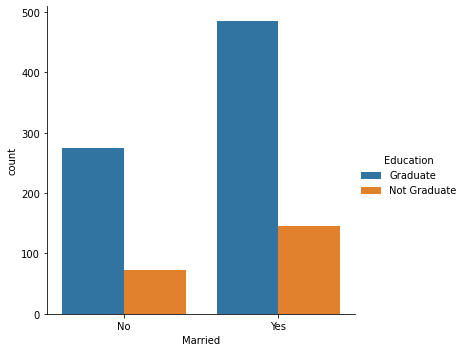

In [152]:
sns.catplot(x='Married', hue='Education', data=data, kind='count')

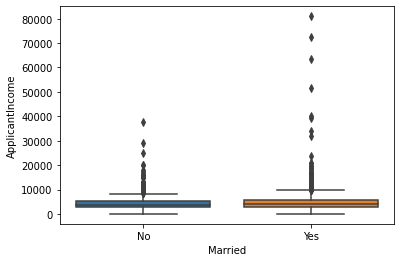

In [153]:
sns.boxplot(x='Married', y='ApplicantIncome', data=data)

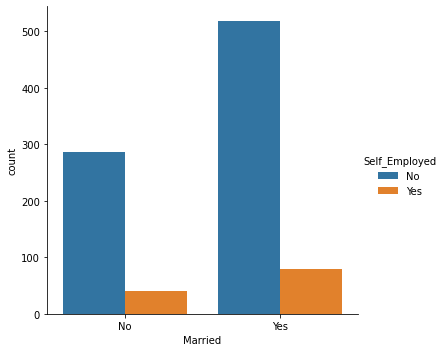

In [154]:
sns.catplot(x='Married', hue='Self_Employed', data=data, kind='count')

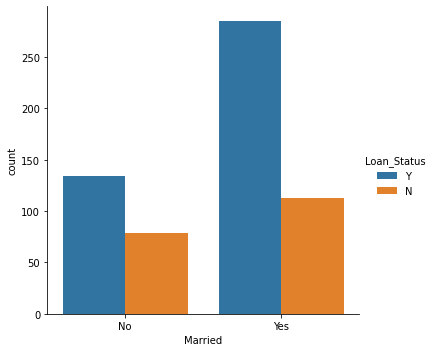

In [155]:
sns.catplot(kind='count', x='Married', hue='Loan_Status', data=data)

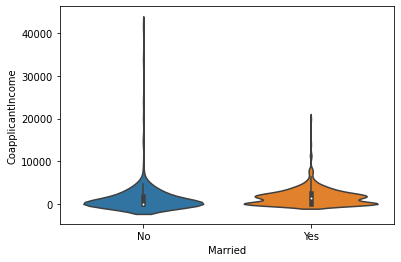

In [156]:
sns.violinplot(x='Married', y='CoapplicantIncome', data=data)

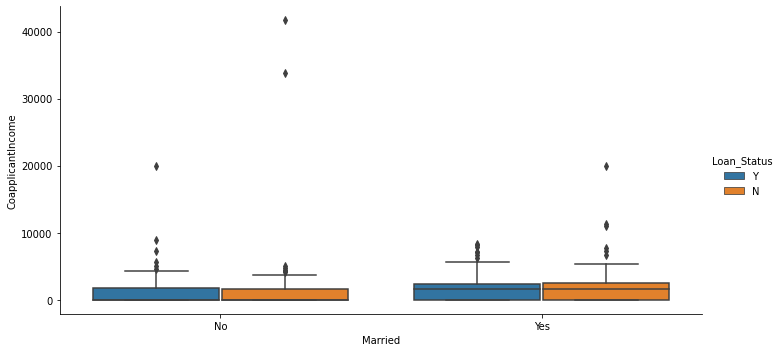

In [157]:
sns.catplot(kind='box', x='Married', y='CoapplicantIncome', hue='Loan_Status', data=data, aspect=2)

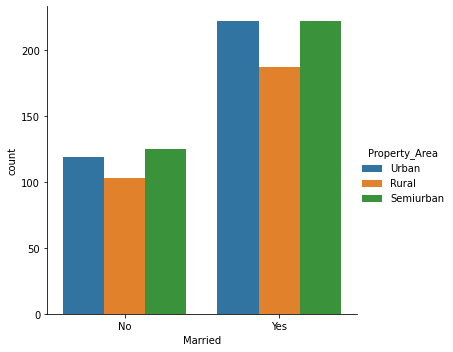

In [158]:
sns.catplot(kind='count', x='Married', hue='Property_Area', data=data)

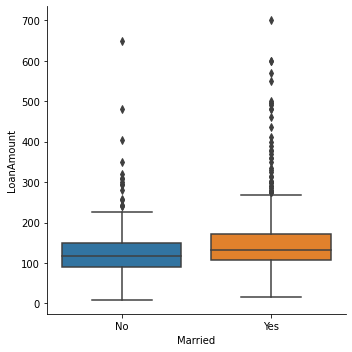

In [159]:
sns.catplot(kind='box', x='Married', y='LoanAmount',data=data)

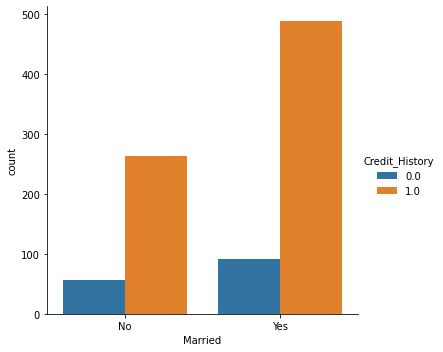

In [160]:
sns.catplot(kind='count', x='Married', hue='Credit_History', data=data)

## Dependents

- Majority of the data points do not have any related dependents
- The educated graduates tend to have less dependents
- Self Employed people have lesser dependents comparatively 
- People with more than 3 or equivalent to 3 dependents have larger applicant income
- The coapplicant income seems larger for the dependents=2
- The Loan Amount is greater with larger number of dependents
- The best credit history is with people who have zero dependents, indicating negative correlation
- The highest number of properties are present in the Semi-urban or Urban areas
- Best case for approvals is when there is no dependents at all
- Married couples having no dependents have lesser chance of getting loan approved

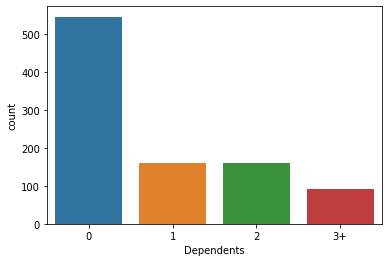

In [161]:
sns.countplot(data['Dependents'])

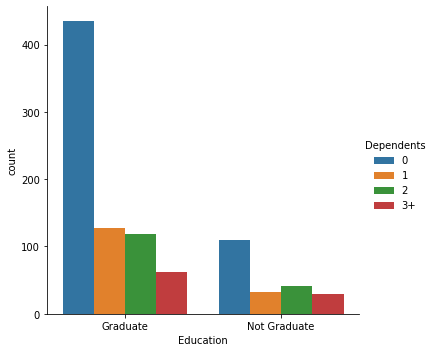

In [162]:
sns.catplot(kind='count', x='Education', hue='Dependents', data=data)

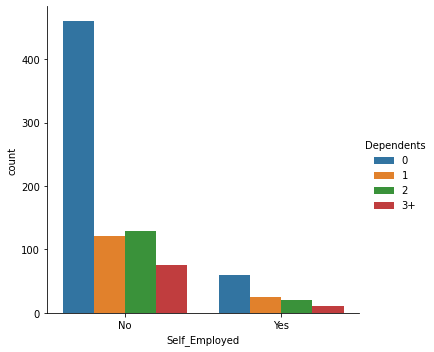

In [163]:
sns.catplot(kind='count', x='Self_Employed', hue='Dependents', data=data)

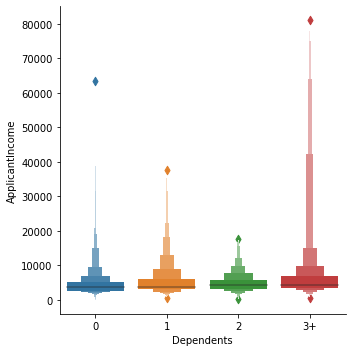

In [164]:
sns.catplot(kind='boxen', x='Dependents', y='ApplicantIncome', data=data)

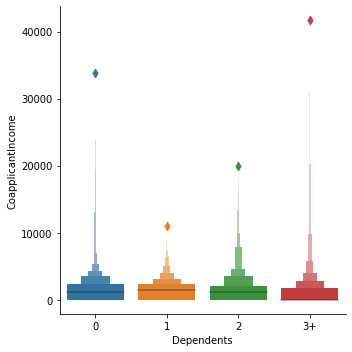

In [165]:
sns.catplot(x='Dependents', y='CoapplicantIncome', data=data, kind='boxen')

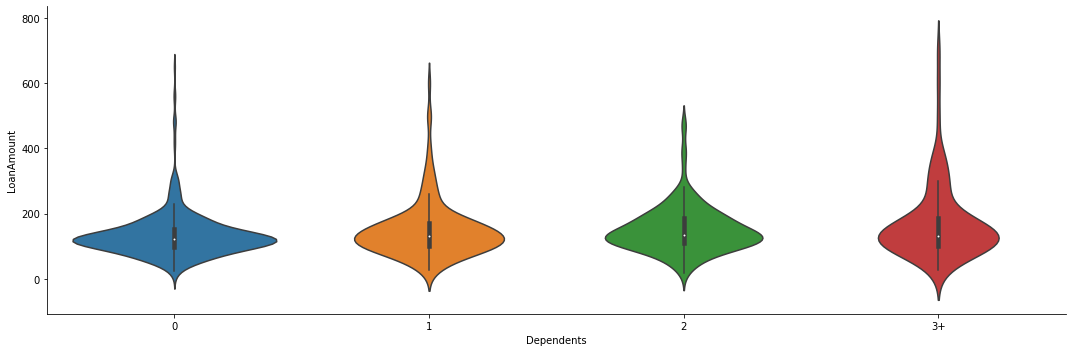

In [166]:
sns.catplot(kind='violin', x='Dependents', y='LoanAmount', data=data, aspect=3)

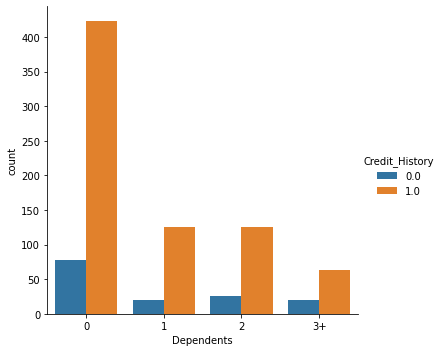

In [167]:
sns.catplot(kind='count', x='Dependents', hue='Credit_History', data=data)

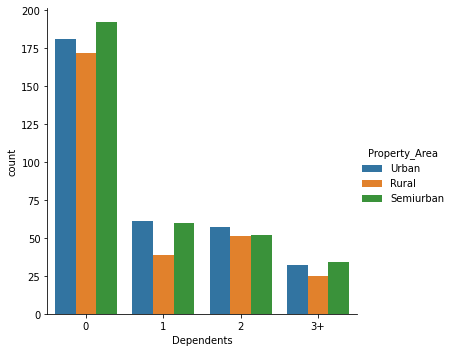

In [168]:
sns.catplot(x='Dependents', hue='Property_Area', data=data, kind='count')

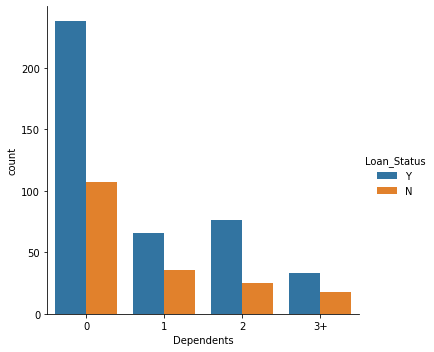

In [169]:
sns.catplot(kind='count', x='Dependents', hue='Loan_Status', data=data)

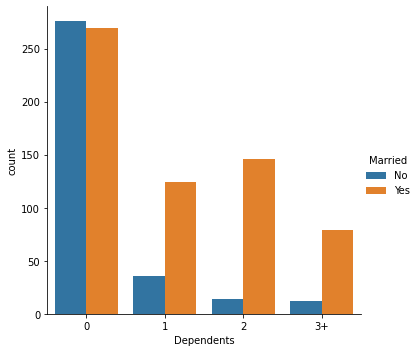

In [170]:
sns.catplot(kind='count', hue='Married', x='Dependents', data=data)

## Education

- There are more number of Graduates than Non-Graduates
- Graduates have larger chance of Loan Status Approval to Yes
- Graduates have higher incomes compared to Non-Graduates
- There are many outliers in the Coapplicant Graduates Income
- The Loan Amount sanctioned have almost same median for any level of education
- Graduates have a better credit history, and are rarely self-employed
- Graduates live more in Urban and Semi-urban areas

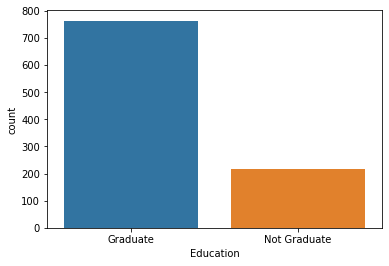

In [171]:
sns.countplot(x='Education', data=data)

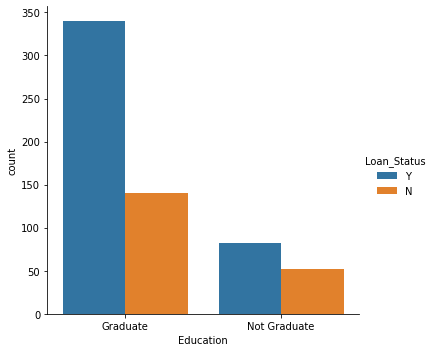

In [172]:
sns.catplot(x='Education', hue='Loan_Status', kind='count', data=data)

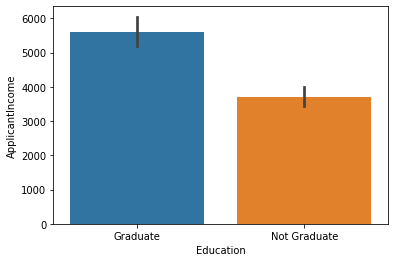

In [173]:
sns.barplot(x='Education', y='ApplicantIncome', data=data)

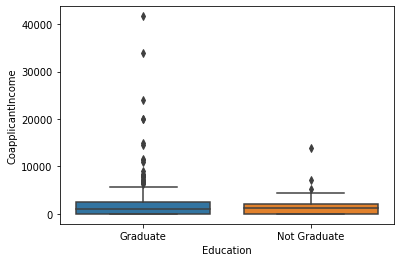

In [174]:
sns.boxplot(x='Education', y='CoapplicantIncome', data=data)

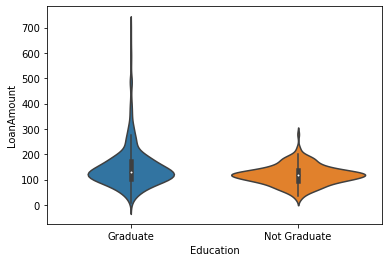

In [175]:
sns.violinplot(x='Education', y='LoanAmount', data=data)

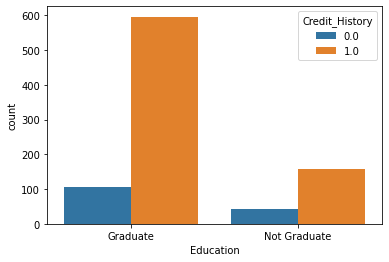

In [176]:
sns.countplot(x='Education', hue='Credit_History', data=data)

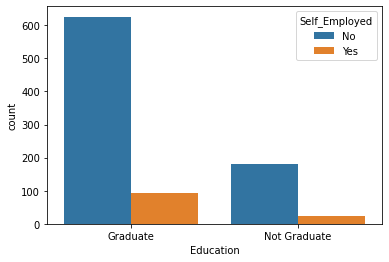

In [177]:
sns.countplot(x='Education', hue='Self_Employed', data=data)

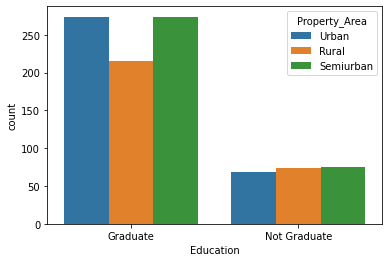

In [178]:
sns.countplot(x='Education', hue='Property_Area', data=data)

## Self-Employed

- The number of Self-Employed is very less compared to the number of other employed 
- Married are least self-employed
- Men are more self-employed
- The self-employed have higher incomes
- They have lesser coapplicant income capacity
- Self-Employed have higher loan amounts
- They live more in Rural Areas
- Loan Status is not directly impacted by this feature and so does Credit History

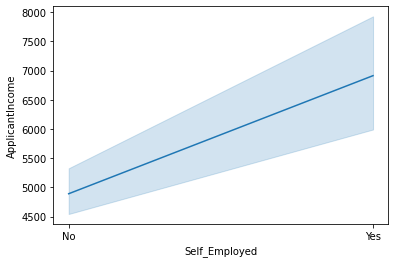

In [179]:
sns.lineplot(x='Self_Employed', y='ApplicantIncome', data=data)

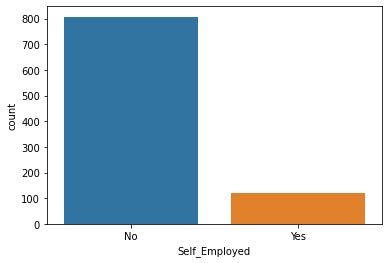

In [180]:
sns.countplot(data['Self_Employed'])

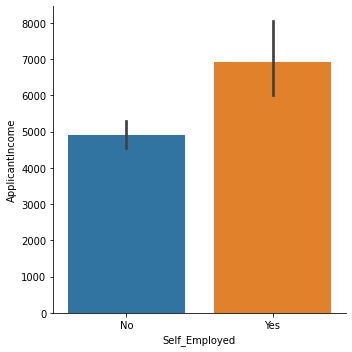

In [181]:
sns.catplot(x='Self_Employed', y='ApplicantIncome', data=data, kind='bar')

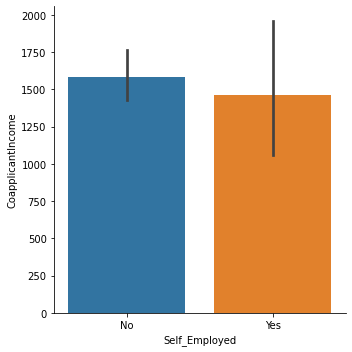

In [182]:
sns.catplot(x='Self_Employed', y='CoapplicantIncome', data=data, kind='bar')

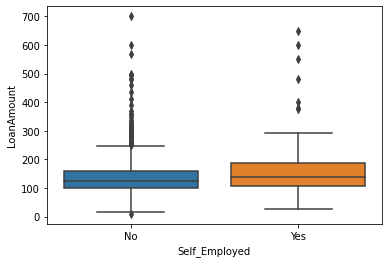

In [183]:
sns.boxplot(x='Self_Employed', y='LoanAmount', data=data)

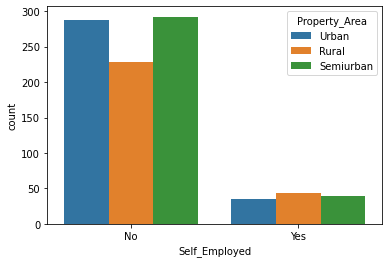

In [184]:
sns.countplot(x='Self_Employed', hue='Property_Area', data=data)

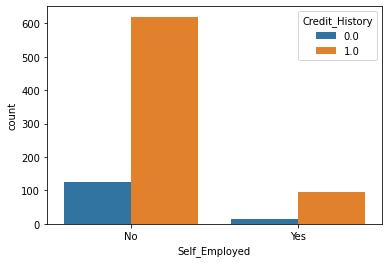

In [185]:
sns.countplot(x='Self_Employed', hue='Credit_History', data=data)

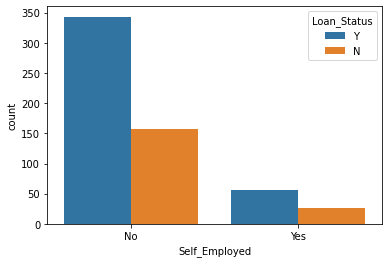

In [186]:
sns.countplot(data=data, x='Self_Employed', hue='Loan_Status')

## Applicant Income, Co-Applicant Income, Loan Amount and Credit History

- The Loan Status is highly correlated with the Credit History which is the capability to pay back debt and makes sense
- The Loan Amount and the Applicant Income are also highly correlated
- Rest of the features are mostly independent and contribute to a certain degree towards the Loan Status

In [595]:
data['Loan_Status'] = data['Loan_Status'].map({'Y':1, 'N':0})

In [579]:
data['Loan_Status'].value_counts()

1.0    422
0.0    192
Name: Loan_Status, dtype: int64

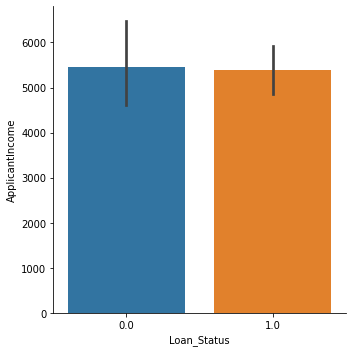

In [145]:
sns.catplot(kind='bar', x='Loan_Status', y='ApplicantIncome', data=data)

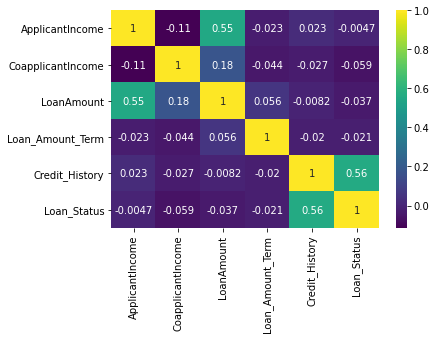

In [127]:
sns.heatmap(data.corr(), cmap='viridis', annot=True)

## Property Area, Loan Terms and Credit History

- Semi-Urban areas have the best records for credit history and thereby best loan approvals too
- Credit History seems to be the most significant aspect of the Loan Status
- Short Term Loans have better chances to be approved

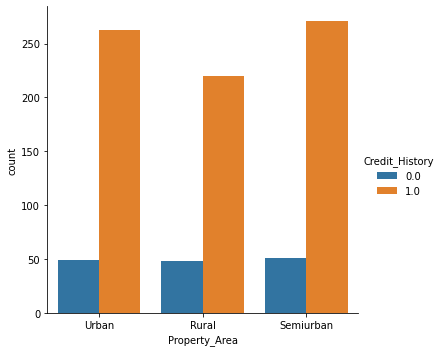

In [129]:
sns.catplot(kind='count', x='Property_Area', hue='Credit_History', data=data)

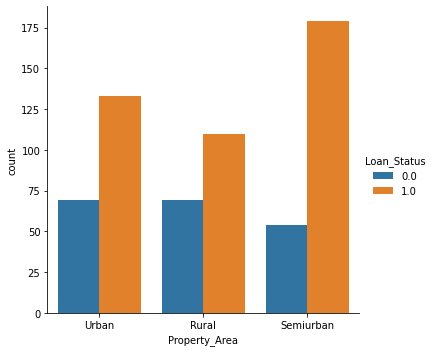

In [130]:
sns.catplot(kind='count', x='Property_Area', hue='Loan_Status', data=data)

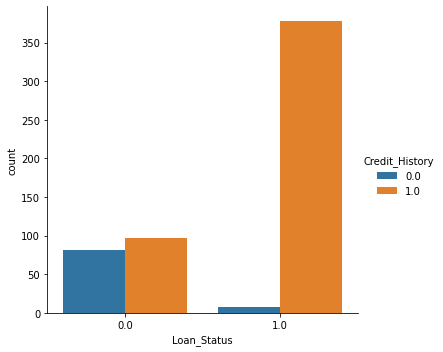

In [131]:
sns.catplot(kind='count', x='Loan_Status', hue='Credit_History', data=data)

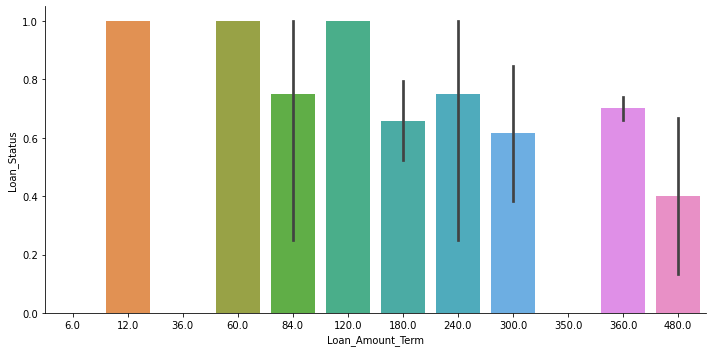

In [147]:
sns.catplot(x='Loan_Amount_Term', y='Loan_Status', kind='bar', data=data, aspect=2)

## Mapping Categorical Values to Numerical

- Gender and Married seems to be bit correlated
- Loan Status is most affected by the Property Area and Credit History
- Loan Applicant Income gives a good insight into Loan Amount that can be sanctioned

In [819]:
data['Loan_Status'] = data['Loan_Status'].map({'Y':1, 'N':0})

In [820]:
data['Property_Area'] = data['Property_Area'].map({'Urban':1, 'Rural':0, 'Semiurban':2})

In [821]:
data['Self_Employed'] = data['Self_Employed'].map({'Yes':1, 'No':0})

In [822]:
data['Married'] = data['Married'].map({'Yes':1, 'No':0})

In [823]:
data['Education'] = data['Education'].map({'Graduate':1, 'Not Graduate':0})

In [824]:
data['Gender'] = data['Gender'].map({'Male':1, 'Female':0})

In [825]:
data['Dependents'] = data['Dependents'].map({'1':1, '2':2, '3+':3})

In [740]:
dummy_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
              'Credit_History', 'Property_Area']
train_data = pd.get_dummies(data[dummy_cols], drop_first = True)
train_data

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
0,1.0,0.0,NaN,1,0.0,1.0,1
1,1.0,1.0,1.0,1,0.0,1.0,0
2,1.0,1.0,NaN,1,1.0,1.0,1
3,1.0,1.0,NaN,0,0.0,1.0,1
4,1.0,0.0,NaN,1,0.0,1.0,1
...,...,...,...,...,...,...,...
362,1.0,1.0,3.0,0,1.0,1.0,1
363,1.0,1.0,NaN,1,0.0,1.0,1
364,1.0,0.0,NaN,1,0.0,NaN,2
365,1.0,1.0,NaN,1,0.0,1.0,0


In [728]:
data

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
0,1.0,0.0,NaN,1,0.0,1.0,1
1,1.0,1.0,1.0,1,0.0,1.0,0
2,1.0,1.0,NaN,1,1.0,1.0,1
3,1.0,1.0,NaN,0,0.0,1.0,1
4,1.0,0.0,NaN,1,0.0,1.0,1
...,...,...,...,...,...,...,...
362,1.0,1.0,3.0,0,1.0,1.0,1
363,1.0,1.0,NaN,1,0.0,1.0,1
364,1.0,0.0,NaN,1,0.0,NaN,2
365,1.0,1.0,NaN,1,0.0,1.0,0


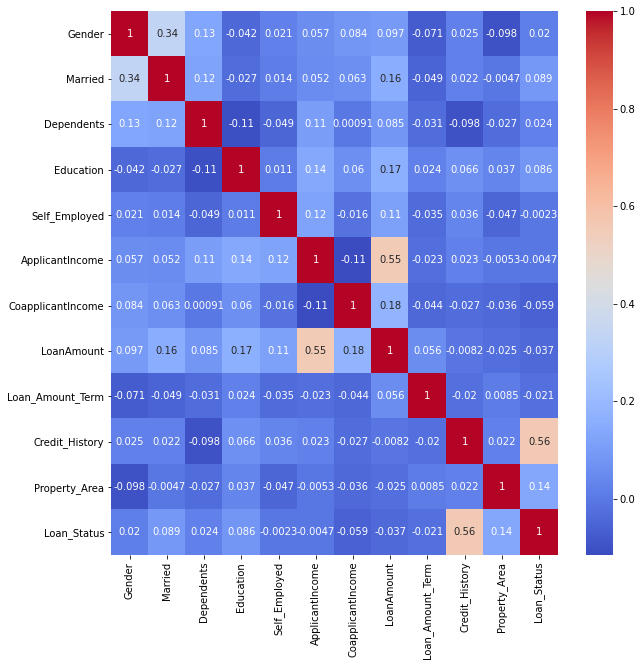

In [408]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, ax=ax)


# Summary

- Males get more approvals than females owing to better Credit History that seems to be the driving factor here, and also the number of males is much more than the number of females.
- Contrary to expectation, higher income does not guarantee loan approval, infact there are lesser approvals slightly for higher incomes. 
- Married couples do have better chance of loan approvals.
- There is no correlation directly between self-employed and loan approvals.
- No dependents is the ideal case for loan approvals and having more does decrease the chances.
- Educated Graduates have higher incomes, better credit histories and hence more chances of getting a loan.
- The Loan for short terms do have higher approval rates.
- Credit History seems to be the most significant parameter in predicting loan approval
- Urban Areas do have more sophisticated crowd and employed along with better chances to gain a home loan.

# Feature Engineering

In [741]:
data.isna().sum()

Loan_ID                0
Gender                24
Married                3
Dependents           570
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
source                 0
dtype: int64

In [826]:
data['Gender'].value_counts()

1.0    775
0.0    182
Name: Gender, dtype: int64

In [827]:
data['Gender'] = data['Gender'].replace(np.nan, 1)
data['Gender'].value_counts()

1.0    799
0.0    182
Name: Gender, dtype: int64

In [828]:
data['Married'].value_counts()

1.0    631
0.0    347
Name: Married, dtype: int64

In [829]:
#data['Married'].fillna(data['Married'].mode()[0], inplace=True)
#data['Married'].value_counts()

data.Married.fillna(np.random.randint(0,2), inplace=True)
data.Married.value_counts()

1.0    634
0.0    347
Name: Married, dtype: int64

In [830]:
data['Dependents'].value_counts()

2.0    160
1.0    160
3.0     91
Name: Dependents, dtype: int64

In [831]:
#data['Dependents'] = data['Dependents'].replace(np.nan, 2)
data['Dependents'].fillna(method='bfill', inplace=True)
data['Dependents'].value_counts()

2.0    385
1.0    384
3.0    208
Name: Dependents, dtype: int64

In [832]:
data['Dependents'].isna().sum()

4

In [833]:
# Fill the rest with 2 
data['Dependents'] = data['Dependents'].replace(np.nan, 2.0)
data['Dependents'].isna().sum()

0

In [834]:
data['Self_Employed'].value_counts()

0.0    807
1.0    119
Name: Self_Employed, dtype: int64

In [835]:
data['Self_Employed'] = data['Self_Employed'].replace(np.nan, 1)
data['Self_Employed'].value_counts()

0.0    807
1.0    174
Name: Self_Employed, dtype: int64

In [836]:
data['Loan_Amount_Term'].value_counts()

360.0    823
180.0     66
480.0     23
300.0     20
240.0      8
84.0       7
120.0      4
36.0       3
60.0       3
12.0       2
350.0      1
6.0        1
Name: Loan_Amount_Term, dtype: int64

In [837]:
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
data['Loan_Amount_Term'].value_counts()

360.0    843
180.0     66
480.0     23
300.0     20
240.0      8
84.0       7
120.0      4
36.0       3
60.0       3
12.0       2
350.0      1
6.0        1
Name: Loan_Amount_Term, dtype: int64

In [838]:
data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)
data['LoanAmount'].value_counts()

126.0    35
120.0    29
110.0    27
100.0    24
187.0    21
         ..
196.0     1
400.0     1
250.0     1
500.0     1
156.0     1
Name: LoanAmount, Length: 232, dtype: int64

In [839]:
data['Credit_History'].value_counts()

1.0    754
0.0    148
Name: Credit_History, dtype: int64

In [840]:
data['Credit_History'].fillna(method='ffill', inplace=True)
data['Credit_History'].value_counts()

1.0    819
0.0    162
Name: Credit_History, dtype: int64

In [841]:
data['Dependents'].value_counts()

2.0    389
1.0    384
3.0    208
Name: Dependents, dtype: int64

In [842]:
data.isna().sum()

Loan_ID                0
Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount             0
Loan_Amount_Term       0
Credit_History         0
Property_Area          0
Loan_Status          367
source                 0
dtype: int64

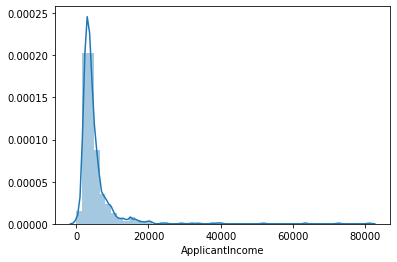

In [843]:
sns.distplot(data['ApplicantIncome'])

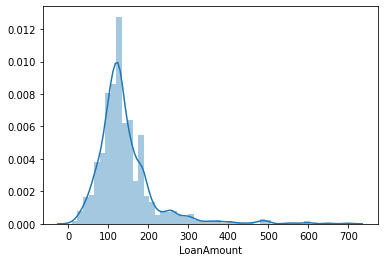

In [844]:
sns.distplot(data['LoanAmount'])

In [845]:
data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['Total_Income'] = np.log(data['Total_Income'])

In [846]:
data['EMI'] = data['LoanAmount']/data['Loan_Amount_Term']

In [847]:
data['Balance'] = data['Total_Income'] - (data['EMI'])

In [848]:
data['Coapplicant_Capacity'] = data['CoapplicantIncome']/data['LoanAmount']
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source,Total_Income,EMI,Balance,Coapplicant_Capacity
0,LP001002,1.0,0.0,1.0,1,0.0,5849,0.0,126.0,360.0,1.0,1,1.0,train,8.674026,0.350000,8.324026,0.000000
1,LP001003,1.0,1.0,1.0,1,0.0,4583,1508.0,128.0,360.0,1.0,0,0.0,train,8.714568,0.355556,8.359012,11.781250
2,LP001005,1.0,1.0,2.0,1,1.0,3000,0.0,66.0,360.0,1.0,1,1.0,train,8.006368,0.183333,7.823034,0.000000
3,LP001006,1.0,1.0,2.0,0,0.0,2583,2358.0,120.0,360.0,1.0,1,1.0,train,8.505323,0.333333,8.171990,19.650000
4,LP001008,1.0,0.0,2.0,1,0.0,6000,0.0,141.0,360.0,1.0,1,1.0,train,8.699515,0.391667,8.307848,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,1.0,1.0,3.0,0,1.0,4009,1777.0,113.0,360.0,1.0,1,NaN,test,8.663196,0.313889,8.349308,15.725664
363,LP002975,1.0,1.0,2.0,1,0.0,4158,709.0,115.0,360.0,1.0,1,NaN,test,8.490233,0.319444,8.170789,6.165217
364,LP002980,1.0,0.0,2.0,1,0.0,3250,1993.0,126.0,360.0,1.0,2,NaN,test,8.564649,0.350000,8.214649,15.817460
365,LP002986,1.0,1.0,2.0,1,0.0,5000,2393.0,158.0,360.0,1.0,0,NaN,test,8.908289,0.438889,8.469400,15.145570


In [849]:
data['LoanAmount'] = np.log(data['LoanAmount'])

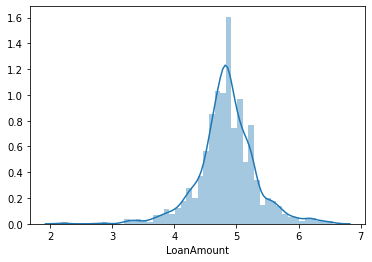

In [850]:
sns.distplot(data['LoanAmount'])

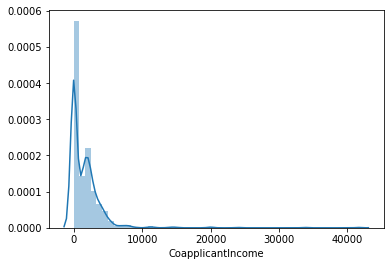

In [851]:
sns.distplot(data['CoapplicantIncome'])

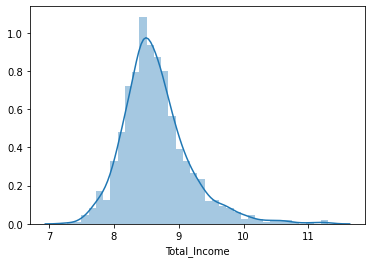

In [852]:
sns.distplot(data['Total_Income'])

In [853]:
# There are 429 coapplicants who even are not paying any amount
(data['Coapplicant_Capacity']==0).value_counts()

False    552
True     429
Name: Coapplicant_Capacity, dtype: int64

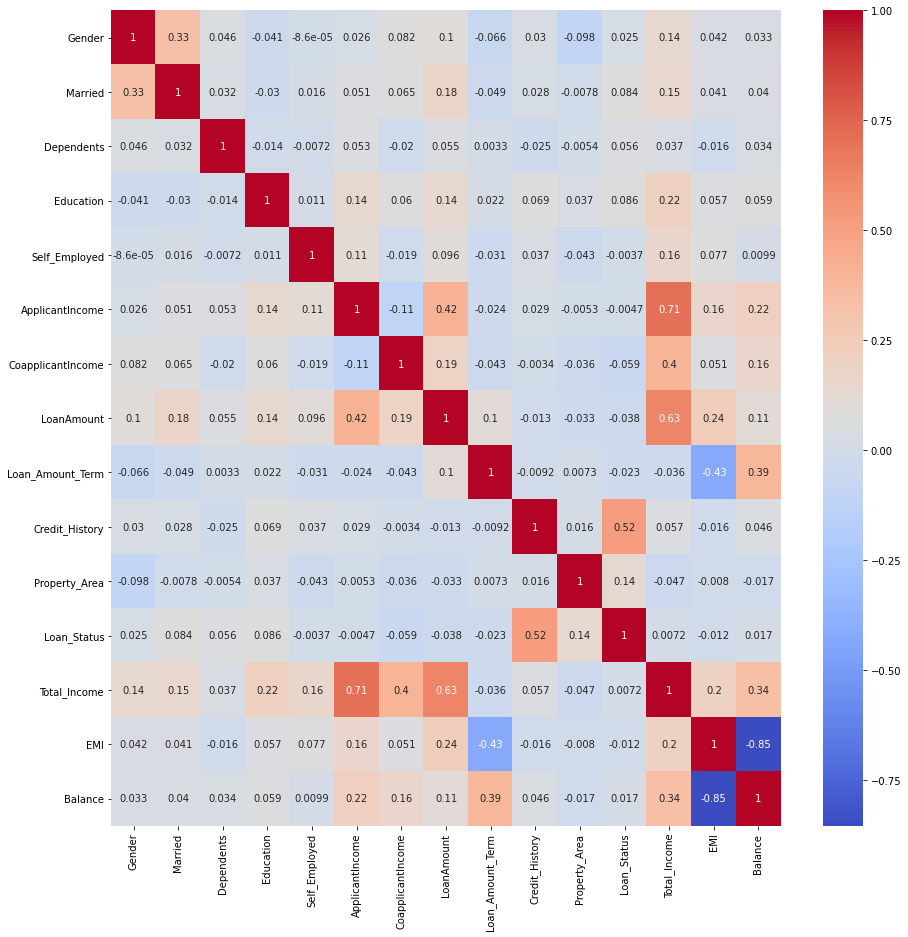

In [679]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, ax=ax)

In [470]:
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source,Total_Income,EMI,Balance,Coapplicant_Capacity
0,LP001002,1.0,0.0,1.0,1,0.0,5849,0.0,4.836282,360.0,1.0,1,1.0,train,8.674026,0.350000,8.324026,0.000000
1,LP001003,1.0,1.0,1.0,1,0.0,4583,1508.0,4.852030,360.0,1.0,0,0.0,train,8.714568,0.355556,8.359012,11.781250
2,LP001005,1.0,1.0,1.0,1,1.0,3000,0.0,4.189655,360.0,1.0,1,1.0,train,8.006368,0.183333,7.823034,0.000000
3,LP001006,1.0,1.0,1.0,0,0.0,2583,2358.0,4.787492,360.0,1.0,1,1.0,train,8.505323,0.333333,8.171990,19.650000
4,LP001008,1.0,0.0,1.0,1,0.0,6000,0.0,4.948760,360.0,1.0,1,1.0,train,8.699515,0.391667,8.307848,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,1.0,1.0,3.0,0,1.0,4009,1777.0,4.727388,360.0,1.0,1,NaN,test,8.663196,0.313889,8.349308,15.725664
363,LP002975,1.0,1.0,1.0,1,0.0,4158,709.0,4.744932,360.0,1.0,1,NaN,test,8.490233,0.319444,8.170789,6.165217
364,LP002980,1.0,0.0,1.0,1,0.0,3250,1993.0,4.836282,360.0,1.0,2,NaN,test,8.564649,0.350000,8.214649,15.817460
365,LP002986,1.0,1.0,1.0,1,0.0,5000,2393.0,5.062595,360.0,1.0,0,NaN,test,8.908289,0.438889,8.469400,15.145570


In [867]:
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income', 'EMI', 'Balance']
data_num = np.abs((data[num_cols] - data[num_cols].mean()) / data[num_cols].std())
data_num

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,EMI,Balance
0,0.306313,0.024482,0.371660,0.322379,0.232472,0.094762,0.117230
1,0.289644,0.062329,0.354708,0.322379,0.444851,0.101120,0.076053
2,0.051321,0.024482,0.345054,0.322379,0.755196,0.025267,0.085642
3,0.044676,0.397904,0.652653,0.322379,0.703437,0.075689,0.159435
4,0.341075,0.024482,0.732940,0.322379,0.365996,0.142446,0.136270
...,...,...,...,...,...,...,...
362,0.283604,0.104082,0.645930,0.322379,0.175741,0.053437,0.087475
363,0.317905,0.327517,0.746971,0.322379,0.624387,0.059795,0.158021
364,0.108874,0.215193,0.371660,0.322379,0.552718,0.094762,0.209643
365,0.193646,0.379900,0.077340,0.322379,0.107266,0.171050,0.053869


In [870]:
dummy_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
              'Credit_History', 'Property_Area']
cat_data = pd.get_dummies(data[dummy_cols], drop_first=True)
cat_data

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
0,1,0,0,1,0,1,1
1,1,1,0,1,0,1,0
2,1,1,1,1,1,1,1
3,1,1,1,0,0,1,1
4,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...
362,1,1,0,0,1,1,1
363,1,1,1,1,0,1,1
364,1,0,1,1,0,1,0
365,1,1,1,1,0,1,0


In [863]:
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source,Total_Income,EMI,Balance,Coapplicant_Capacity
0,LP001002,1,0,0,1,0,0.420219,0.026780,0.969871,0.356974,1,1,1.0,train,1.022741,0.125095,0.208120,0.000000
1,LP001003,1,1,0,1,0,0.434759,0.646834,0.978765,0.356974,1,0,0.0,train,0.907436,0.131207,0.169961,11.781250
2,LP001005,1,1,1,1,1,0.116877,0.026780,0.983829,0.356974,1,1,1.0,train,0.738944,0.058280,0.020114,0.000000
3,LP001006,1,1,1,0,0,0.033140,0.351048,0.822458,0.356974,1,1,1.0,train,0.680143,0.106757,0.373949,19.650000
4,LP001008,1,0,1,1,0,0.389896,0.026780,0.686509,0.356974,1,1,1.0,train,0.950248,0.170939,0.225766,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,1,1,0,0,1,0.319495,0.610577,0.640862,0.356974,1,1,NaN,test,1.053541,0.085364,0.180545,15.725664
363,LP002975,1,1,1,1,0,0.349415,0.289926,0.693870,0.356974,1,1,NaN,test,0.637225,0.091476,0.375259,6.165217
364,LP002980,1,0,1,1,0,0.167080,0.514091,0.969871,0.356974,1,0,NaN,test,0.848873,0.125095,0.327419,15.817460
365,LP002986,1,1,1,1,0,0.518497,0.335414,0.342570,0.356974,1,0,NaN,test,0.356470,0.222895,0.049559,15.145570


In [776]:
final = data[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'CoapplicantIncome', 'LoanAmount',
             'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'source', 'Total_Income', 
              'EMI', 'Balance']]

In [777]:
train_final = final.loc[final['source']=='train']
train_final

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source,Total_Income,EMI,Balance
0,1.0,0.0,1.0,1,0.0,0.0,4.836282,360.0,1.0,1,1.0,train,8.674026,0.350000,8.324026
1,1.0,1.0,1.0,1,0.0,1508.0,4.852030,360.0,1.0,0,0.0,train,8.714568,0.355556,8.359012
2,1.0,1.0,2.0,1,1.0,0.0,4.189655,360.0,1.0,1,1.0,train,8.006368,0.183333,7.823034
3,1.0,1.0,2.0,0,0.0,2358.0,4.787492,360.0,1.0,1,1.0,train,8.505323,0.333333,8.171990
4,1.0,0.0,2.0,1,0.0,0.0,4.948760,360.0,1.0,1,1.0,train,8.699515,0.391667,8.307848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,3.0,1,0.0,0.0,4.262680,360.0,1.0,0,1.0,train,7.972466,0.197222,7.775244
610,1.0,1.0,3.0,1,0.0,0.0,3.688879,180.0,1.0,0,1.0,train,8.320205,0.222222,8.097982
611,1.0,1.0,1.0,1,0.0,240.0,5.533389,360.0,1.0,1,1.0,train,9.025456,0.702778,8.322678
612,1.0,1.0,2.0,1,0.0,0.0,5.231109,360.0,1.0,1,1.0,train,8.933664,0.519444,8.414220


In [778]:
test_final = final.loc[final['source']=='test']
test_final

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,source,Total_Income,EMI,Balance
0,1.0,1.0,1.0,1,0.0,0.0,4.700480,360.0,1.0,1,NaN,test,8.651724,0.305556,8.346169
1,1.0,1.0,1.0,1,0.0,1500.0,4.836282,360.0,1.0,1,NaN,test,8.428581,0.350000,8.078581
2,1.0,1.0,2.0,1,0.0,1800.0,5.337538,360.0,1.0,1,NaN,test,8.824678,0.577778,8.246900
3,1.0,1.0,2.0,1,0.0,2546.0,4.605170,360.0,1.0,1,NaN,test,8.494129,0.277778,8.216351
4,1.0,0.0,1.0,0,0.0,0.0,4.356709,360.0,1.0,1,NaN,test,8.094378,0.216667,7.877712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,3.0,0,1.0,1777.0,4.727388,360.0,1.0,1,NaN,test,8.663196,0.313889,8.349308
363,1.0,1.0,3.0,1,0.0,709.0,4.744932,360.0,1.0,1,NaN,test,8.490233,0.319444,8.170789
364,1.0,0.0,3.0,1,0.0,1993.0,4.836282,360.0,1.0,2,NaN,test,8.564649,0.350000,8.214649
365,1.0,1.0,3.0,1,0.0,2393.0,5.062595,360.0,1.0,0,NaN,test,8.908289,0.438889,8.469400


In [779]:
test_final.isna().sum()

Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
CoapplicantIncome      0
LoanAmount             0
Loan_Amount_Term       0
Credit_History         0
Property_Area          0
Loan_Status          367
source                 0
Total_Income           0
EMI                    0
Balance                0
dtype: int64

In [780]:
test_final['Dependents'].fillna(method='ffill', inplace=True)
test_final['Dependents'].value_counts()

/home/vipul/.local/lib/python3.8/site-packages/pandas/core/generic.py:6244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


1.0    140
2.0    134
3.0     93
Name: Dependents, dtype: int64

In [781]:
test_final.isna().sum()

Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
CoapplicantIncome      0
LoanAmount             0
Loan_Amount_Term       0
Credit_History         0
Property_Area          0
Loan_Status          367
source                 0
Total_Income           0
EMI                    0
Balance                0
dtype: int64

In [782]:
train_final = train_final.drop(columns=['source'], axis=1)
test_final = test_final.drop(columns=['source', 'Loan_Status'], axis=1)

In [783]:
train_final

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,EMI,Balance
0,1.0,0.0,1.0,1,0.0,0.0,4.836282,360.0,1.0,1,1.0,8.674026,0.350000,8.324026
1,1.0,1.0,1.0,1,0.0,1508.0,4.852030,360.0,1.0,0,0.0,8.714568,0.355556,8.359012
2,1.0,1.0,2.0,1,1.0,0.0,4.189655,360.0,1.0,1,1.0,8.006368,0.183333,7.823034
3,1.0,1.0,2.0,0,0.0,2358.0,4.787492,360.0,1.0,1,1.0,8.505323,0.333333,8.171990
4,1.0,0.0,2.0,1,0.0,0.0,4.948760,360.0,1.0,1,1.0,8.699515,0.391667,8.307848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,3.0,1,0.0,0.0,4.262680,360.0,1.0,0,1.0,7.972466,0.197222,7.775244
610,1.0,1.0,3.0,1,0.0,0.0,3.688879,180.0,1.0,0,1.0,8.320205,0.222222,8.097982
611,1.0,1.0,1.0,1,0.0,240.0,5.533389,360.0,1.0,1,1.0,9.025456,0.702778,8.322678
612,1.0,1.0,2.0,1,0.0,0.0,5.231109,360.0,1.0,1,1.0,8.933664,0.519444,8.414220


In [784]:
test_final

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,EMI,Balance
0,1.0,1.0,1.0,1,0.0,0.0,4.700480,360.0,1.0,1,8.651724,0.305556,8.346169
1,1.0,1.0,1.0,1,0.0,1500.0,4.836282,360.0,1.0,1,8.428581,0.350000,8.078581
2,1.0,1.0,2.0,1,0.0,1800.0,5.337538,360.0,1.0,1,8.824678,0.577778,8.246900
3,1.0,1.0,2.0,1,0.0,2546.0,4.605170,360.0,1.0,1,8.494129,0.277778,8.216351
4,1.0,0.0,1.0,0,0.0,0.0,4.356709,360.0,1.0,1,8.094378,0.216667,7.877712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,3.0,0,1.0,1777.0,4.727388,360.0,1.0,1,8.663196,0.313889,8.349308
363,1.0,1.0,3.0,1,0.0,709.0,4.744932,360.0,1.0,1,8.490233,0.319444,8.170789
364,1.0,0.0,3.0,1,0.0,1993.0,4.836282,360.0,1.0,2,8.564649,0.350000,8.214649
365,1.0,1.0,3.0,1,0.0,2393.0,5.062595,360.0,1.0,0,8.908289,0.438889,8.469400


In [785]:
X = train_final.drop(columns=['Loan_Status'], axis=1)
y = train_final['Loan_Status']

In [786]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [787]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,EMI,Balance
355,0.0,0.0,2.0,1,0.0,0.0,4.753590,180.0,1.0,1,8.246172,0.644444,7.601727
20,1.0,1.0,1.0,0,0.0,0.0,4.644391,360.0,0.0,1,8.943767,0.288889,8.654878
501,0.0,0.0,2.0,1,0.0,0.0,4.605170,360.0,1.0,2,8.058011,0.277778,7.780233
493,0.0,0.0,1.0,0,1.0,0.0,5.416100,360.0,1.0,2,9.756321,0.625000,9.131321
200,1.0,1.0,1.0,0,0.0,2500.0,4.499810,360.0,1.0,2,8.536996,0.250000,8.286996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.0,0.0,1.0,1,0.0,0.0,4.753590,360.0,0.0,2,8.334712,0.322222,8.012489
209,1.0,0.0,3.0,1,0.0,0.0,4.844187,360.0,1.0,2,8.136811,0.352778,7.784033
338,0.0,0.0,3.0,0,0.0,0.0,4.836282,360.0,0.0,1,7.512071,0.350000,7.162071
507,0.0,0.0,1.0,1,0.0,0.0,4.564348,360.0,1.0,1,8.183956,0.266667,7.917289


In [788]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
accuracy_score(y_test, pred)

0.8455284552845529

In [793]:
X_test.head(9)

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,EMI,Balance
355,0.0,0.0,2.0,1,0.0,0.0,4.753590,180.0,1.0,1,8.246172,0.644444,7.601727
20,1.0,1.0,1.0,0,0.0,0.0,4.644391,360.0,0.0,1,8.943767,0.288889,8.654878
501,0.0,0.0,2.0,1,0.0,0.0,4.605170,360.0,1.0,2,8.058011,0.277778,7.780233
493,0.0,0.0,1.0,0,1.0,0.0,5.416100,360.0,1.0,2,9.756321,0.625000,9.131321
200,1.0,1.0,1.0,0,0.0,2500.0,4.499810,360.0,1.0,2,8.536996,0.250000,8.286996
101,1.0,0.0,1.0,1,0.0,3806.0,5.017280,360.0,1.0,2,9.065199,0.419444,8.645755
531,1.0,1.0,3.0,1,0.0,0.0,4.605170,360.0,1.0,1,8.361942,0.277778,8.084164
337,1.0,1.0,2.0,1,1.0,4600.0,5.170484,360.0,1.0,0,8.867850,0.488889,8.378961
235,1.0,1.0,1.0,1,0.0,1260.0,5.135798,360.0,1.0,0,8.818778,0.472222,8.346556


In [813]:
mask = np.logical_not(np.equal(y_test, pred))
# Now you can use the mask to see the elements bad classified:
print(f"{X_test[mask]}")
print(f"Prediction by the model for each of those elements: {pred[mask]}")
print(f"Actual value for each of those elements: {np.asarray(y_test)[mask]}")

     Gender  Married  Dependents  Education  Self_Employed  CoapplicantIncome  \
533     1.0      0.0         1.0          1            0.0                0.0   
210     0.0      0.0         3.0          1            0.0                0.0   
519     0.0      0.0         2.0          0            0.0                0.0   
9       1.0      1.0         1.0          1            0.0            10968.0   
308     1.0      0.0         2.0          1            0.0                0.0   
447     1.0      1.0         2.0          1            0.0             1376.0   
305     1.0      0.0         2.0          0            0.0                0.0   
457     1.0      1.0         2.0          1            0.0             2569.0   
573     1.0      1.0         2.0          0            0.0             1625.0   
65      1.0      1.0         1.0          1            0.0             4595.0   
568     0.0      0.0         1.0          1            0.0                0.0   
166     0.0      1.0        

In [806]:
X_test.iloc[9]

Gender                 1.000000
Married                0.000000
Dependents             1.000000
Education              1.000000
Self_Employed          0.000000
CoapplicantIncome      0.000000
LoanAmount             5.278115
Loan_Amount_Term     360.000000
Credit_History         1.000000
Property_Area          2.000000
Total_Income           9.328123
EMI                    0.544444
Balance                8.783679
Name: 533, dtype: float64

In [811]:
y_test.iloc[122]

1.0

In [812]:
pred[122]

1.0

In [810]:
X_test.iloc[122]

Gender                 0.000000
Married                0.000000
Dependents             1.000000
Education              0.000000
Self_Employed          0.000000
CoapplicantIncome      0.000000
LoanAmount             3.970292
Loan_Amount_Term     360.000000
Credit_History         1.000000
Property_Area          2.000000
Total_Income           7.582229
EMI                    0.147222
Balance                7.435007
Name: 403, dtype: float64

In [707]:
rf_model = RandomForestClassifier(random_state=1,max_depth=10,n_estimators=50)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
accuracy_score(y_test, pred)

0.7317073170731707

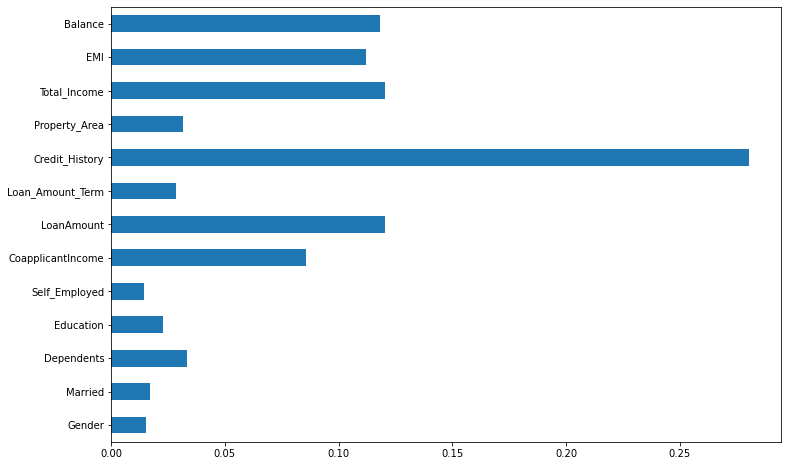

In [708]:
importances = pd.Series(rf_model.feature_importances_,index=X.columns)
importances.plot(kind='barh', figsize=(12,8))

In [709]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
accuracy_score(y_test, pred)

0.7642276422764228

In [710]:
predictions = rf_model.predict(test_final)

In [711]:
predictions

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1.

In [712]:
pred_df = pd.DataFrame(data=predictions)
pred_df[0] = pred_df[0].map({1.0:'Y', 0.0:'N'})
pred_df[0]

0      Y
1      Y
2      Y
3      Y
4      Y
      ..
362    Y
363    Y
364    Y
365    Y
366    Y
Name: 0, Length: 367, dtype: object

In [713]:
pred_df[0].value_counts()

Y    297
N     70
Name: 0, dtype: int64

In [714]:
submission_df = pd.DataFrame({'Loan_ID':test['Loan_ID'], 'Loan_Status':pred_df[0]})
submission_df

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,Y
365,LP002986,Y


In [715]:
submission_df.to_csv("final.csv", index=False)